In [1]:
import pandas as pd
import statsmodels.api as sm
import warnings
import datetime
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")

In [2]:
PATH = './'

## Connect to Google Drive

In [3]:
# #install python 3.10
# !sudo apt-get update -y
# !sudo apt-get install python3.10

# #change alternatives
# !sudo update-alternatives --install /usr/bin/python3 python3 /usr/bin/python3.7 1
# !sudo update-alternatives --install /usr/bin/python3 python3 /usr/bin/python3.10 2


In [4]:
# ! python --version

In [5]:
# from google.colab import drive
# PATH = '/content/drive/'
# print(PATH)
# drive.mount(PATH)

In [6]:
# PATH += 'MyDrive/key_event_data/'

## Cleaning data

In [302]:
df = pd.read_csv(PATH+'combined_df.csv')
df.drop(['datadate', 'fyearq', 'fqtr', 'indfmt','consol','popsrc','datafmt','curcdq', 'datacqtr', 'datafqtr', 'fdateq', 'costat'], axis = 1, inplace= True)

Dropping Redundant Columns, Null handling and fixing categorical types

In [303]:
_ = df.iloc[:,:-42].isna().sum()
_ = _[_ > 0]/df.shape[0]
_ = _[_.apply(lambda x: x > 0.20)]  # dropping cols with > 20% missing data
df = df.drop(_.index.tolist(), axis=1)

df.dropna(subset = ['niq'],inplace=True) # Dropping rows with Nan in NI (target)

print(df.shape)

print('Non Sentiment columns: ', df.columns[:-42])
df

(233904, 61)
Non Sentiment columns:  Index(['gvkey', 'atq', 'cogsq', 'cshoq', 'dlcq', 'dlttq', 'invtq', 'ltq',
       'niq', 'oiadpq', 'oibdpq', 'opepsq', 'req', 'revtq', 'saleq', 'txtq',
       'gind', 'gsector', 'quarter'],
      dtype='object')


,gvkey,atq,cogsq,cshoq,dlcq,dlttq,invtq,ltq,niq,oiadpq,...,neg_Annual General Meeting,neg_Ex-Div Date (Regular),neg_Board Meeting,neg_M&A Transaction Announcements,neg_M&A Transaction Closings,neg_Private Placements,neg_Fixed Income Offerings,neg_Special/Extraordinary Shareholders Meeting,neg_Conferences,neg_Buyback Tranche Update
0,1004,758.503,168.829,26.958,65.396,189.920,340.683,418.356,0.486,5.445,...,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1004,714.208,118.697,26.876,71.162,189.733,265.818,429.864,-54.484,-0.171,...,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1004,690.681,118.267,31.859,20.890,189.665,271.342,375.849,-2.290,0.043,...,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1004,710.199,120.684,31.870,42.525,217.699,286.588,399.964,-2.651,-0.606,...,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1004,722.944,126.417,31.865,41.989,246.822,274.737,416.384,-4.879,-3.016,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
262372,332115,39.516,6.683,18.688,2.273,10.877,0.000,20.659,-6.624,-6.453,...,NaN,NaN,NaN,NaN,NaN,0.027125,NaN,0.0,0.0,NaN
262373,335466,198.908,10.494,31.330,0.414,141.575,2.334,148.618,-6.837,-4.086,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
262374,339965,5712.889,63.832,283.119,19.333,186.718,0.000,745.074,-168.889,-169.454,...,NaN,NaN,NaN,NaN,0.000000,0.000000,NaN,NaN,0.0,NaN
262375,339965,5921.739,79.689,287.918,19.650,184.887,0.000,985.268,-198.935,-200.397,...,NaN,NaN,NaN,NaN,0.010375,NaN,NaN,NaN,0.0,NaN


In [304]:
df.gsector = df.gsector.astype('category')
df.gind = df.gind.astype('category')
df.quarter = df.quarter.astype('category') ## or str?
df.gvkey = df.gvkey.astype('str')
df.iloc[:, :-42].dtypes

gvkey        object
atq         float64
cogsq       float64
cshoq       float64
dlcq        float64
dlttq       float64
invtq       float64
ltq         float64
niq         float64
oiadpq      float64
oibdpq      float64
opepsq      float64
req         float64
revtq       float64
saleq       float64
txtq        float64
gind       category
gsector    category
quarter    category
dtype: object

In [305]:
df.iloc[:,-42:].describe().loc[['min','max']]  # sentiments range from 0 -> 1 (unlikely)

,pos_Executive/Board Changes - Other,pos_Client Announcements,pos_Announcements of Earnings,pos_Corporate Guidance - New/Confirmed,pos_Business Expansions,pos_Product-Related Announcements,pos_Dividend Affirmations,pos_Dividend Increases,pos_Earnings Calls,pos_Company Conference Presentations,...,neg_Annual General Meeting,neg_Ex-Div Date (Regular),neg_Board Meeting,neg_M&A Transaction Announcements,neg_M&A Transaction Closings,neg_Private Placements,neg_Fixed Income Offerings,neg_Special/Extraordinary Shareholders Meeting,neg_Conferences,neg_Buyback Tranche Update
min,0.000,0.0000,0.0000,0.000000,0.000000,0.000,0.000000,0.0000,0.000,0.000,...,0.0000,0.0000,0.0000,0.00000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
max,0.373,0.4125,0.3032,0.391667,0.338667,0.351,0.325844,0.3345,0.512,0.647,...,0.2915,0.3845,0.2735,0.24875,0.333333,0.18075,0.240667,0.229333,0.168429,0.240667


In [306]:
# #fill missing values in the sentiment columns with 0 (or neutral sentiment)
# df.iloc[:,39:] = df.iloc[:,39:].fillna(0)

## Procressing Data

In [307]:
def lag_niq(tdf: pd.DataFrame, num_quarters_prediction: int = 1)-> pd.DataFrame:
    num_quarters_prediction *= -1
    tdf.sort_values(by = 'quarter', inplace = True)
    _ = tdf.niq.pct_change()
    _ = _.apply(lambda x: 0 if x <= 0 else 1)   # We only need the direction of niq change...so pct change works (the magnitude doesn't matter)
    _ = _.shift()

    tdf = tdf.iloc[1:num_quarters_prediction,:]
    tdf['dir'] = _

    return tdf

In [308]:
# lag_niq(df.groupby('gvkey',as_index=False).get_group(1004))

In [309]:
#adding the shifted eps (next quarter eps)
df = df.groupby('gvkey',as_index=False).apply(lag_niq).reset_index(drop=True)
df.dropna(how= 'all', subset= df.columns[:-42], inplace= True)
df

,gvkey,atq,cogsq,cshoq,dlcq,dlttq,invtq,ltq,niq,oiadpq,...,neg_Ex-Div Date (Regular),neg_Board Meeting,neg_M&A Transaction Announcements,neg_M&A Transaction Closings,neg_Private Placements,neg_Fixed Income Offerings,neg_Special/Extraordinary Shareholders Meeting,neg_Conferences,neg_Buyback Tranche Update,dir
0,10000,578.757,111.937,11.795,6.404,237.392,177.187,386.350,3.748,9.202,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
1,10000,509.429,72.953,11.824,5.859,200.066,177.291,323.742,-6.330,-7.023,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
2,10000,523.051,91.253,11.832,2.592,220.260,187.391,358.165,-20.590,0.107,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
3,10000,578.677,129.755,11.946,7.808,242.953,172.491,406.346,5.461,12.381,...,0.0,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,1.0
4,10000,565.446,128.837,11.957,7.471,200.879,161.709,401.975,-7.086,17.092,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
223517,9969,192.741,9.125,44.606,5.881,4.474,16.440,43.401,2.388,3.334,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,1.0
223518,9969,206.865,9.239,44.822,5.087,4.452,17.142,46.981,6.379,2.342,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
223519,9969,206.788,9.502,45.105,4.404,3.744,17.565,41.821,-0.134,-0.985,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,1.0
223520,9969,218.039,8.954,45.788,4.173,3.428,17.836,43.365,-1.172,-0.005,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0


In [310]:
def convert_pct(tdf: pd.DataFrame)-> pd.DataFrame:
    cols = tdf.columns.drop(['quarter','gvkey','dir'])
    tdf = tdf.set_index('quarter').sort_index()
    tdf[[f'pct_{x}' for x in cols]] = tdf[cols].pct_change()
    # print(tdf.columns)
    return tdf.reset_index()

convert_pct(df[['gvkey','quarter','dir','atq','cogsq']].groupby('gvkey', as_index=False).get_group('10000'))

,quarter,gvkey,dir,atq,cogsq,pct_atq,pct_cogsq
0,2001Q3,10000,1.0,578.757,111.937,NaN,NaN
1,2001Q4,10000,0.0,509.429,72.953,-0.119788,-0.348267
2,2002Q1,10000,0.0,523.051,91.253,0.026740,0.250846
3,2002Q2,10000,1.0,578.677,129.755,0.106349,0.421926
4,2002Q3,10000,0.0,565.446,128.837,-0.022864,-0.007075
...,...,...,...,...,...,...,...
72,2019Q3,10000,1.0,920.683,209.118,-0.050379,-0.002780
73,2019Q4,10000,0.0,912.730,161.860,-0.008638,-0.225987
74,2020Q1,10000,0.0,940.711,177.368,0.030656,0.095811
75,2020Q2,10000,0.0,944.765,177.243,0.004310,-0.000705


In [311]:
predictors = list(df.select_dtypes(include= 'float64').columns[:-43])
print(predictors)

['atq', 'cogsq', 'cshoq', 'dlcq', 'dlttq', 'invtq', 'ltq', 'niq', 'oiadpq', 'oibdpq', 'opepsq', 'req', 'revtq', 'saleq', 'txtq']


In [312]:
sentiment = df.iloc[:,-43:].copy().fillna(0.0)
df = df[predictors+['gvkey','quarter','dir']].groupby('gvkey', as_index=False).apply(convert_pct).reset_index(drop=True)
df

,quarter,atq,cogsq,cshoq,dlcq,dlttq,invtq,ltq,niq,oiadpq,...,pct_invtq,pct_ltq,pct_niq,pct_oiadpq,pct_oibdpq,pct_opepsq,pct_req,pct_revtq,pct_saleq,pct_txtq
0,2001Q3,578.757,111.937,11.795,6.404,237.392,177.187,386.350,3.748,9.202,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2001Q4,509.429,72.953,11.824,5.859,200.066,177.291,323.742,-6.330,-7.023,...,0.000587,-0.162050,-2.688901,-1.763204,-1.159515,-2.656250,-0.037657,-0.394826,-0.394826,-2.688506
2,2002Q1,523.051,91.253,11.832,2.592,220.260,187.391,358.165,-20.590,0.107,...,0.056968,0.106328,2.252765,-1.015236,-2.832113,-0.698113,-0.116095,0.309949,0.309949,-0.739278
3,2002Q2,578.677,129.755,11.946,7.808,242.953,172.491,406.346,5.461,12.381,...,-0.079513,0.134522,-1.265226,114.710280,3.083645,-4.312500,0.036562,0.429921,0.429921,-4.124021
4,2002Q3,565.446,128.837,11.957,7.471,200.879,161.709,401.975,-7.086,17.092,...,-0.062508,-0.010757,-2.297565,0.380502,0.280037,0.547170,-0.054454,0.016620,0.016620,0.931885
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
223117,2019Q3,192.741,9.125,44.606,5.881,4.474,16.440,43.401,2.388,3.334,...,0.006859,0.042617,-0.389882,-0.276946,-0.217060,-0.444444,-0.009660,-0.015354,-0.015354,-0.328028
223118,2019Q4,206.865,9.239,44.822,5.087,4.452,17.142,46.981,6.379,2.342,...,0.042701,0.082487,1.671273,-0.297540,-0.249466,1.800000,-0.038825,-0.004404,-0.004404,-5.476316
223119,2020Q1,206.788,9.502,45.105,4.404,3.744,17.565,41.821,-0.134,-0.985,...,0.024676,-0.109832,-1.021006,-1.420581,-1.066414,-1.214286,0.000773,-0.095054,-0.095054,-0.659612
223120,2020Q2,218.039,8.954,45.788,4.173,3.428,17.836,43.365,-1.172,-0.005,...,0.015428,0.036919,7.746269,-0.994924,-4.595238,-0.666667,0.007278,0.000199,0.000199,-1.480138


In [313]:
df[sentiment.columns] = sentiment
df

,quarter,atq,cogsq,cshoq,dlcq,dlttq,invtq,ltq,niq,oiadpq,...,neg_Annual General Meeting,neg_Ex-Div Date (Regular),neg_Board Meeting,neg_M&A Transaction Announcements,neg_M&A Transaction Closings,neg_Private Placements,neg_Fixed Income Offerings,neg_Special/Extraordinary Shareholders Meeting,neg_Conferences,neg_Buyback Tranche Update
0,2001Q3,578.757,111.937,11.795,6.404,237.392,177.187,386.350,3.748,9.202,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2001Q4,509.429,72.953,11.824,5.859,200.066,177.291,323.742,-6.330,-7.023,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2002Q1,523.051,91.253,11.832,2.592,220.260,187.391,358.165,-20.590,0.107,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2002Q2,578.677,129.755,11.946,7.808,242.953,172.491,406.346,5.461,12.381,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2002Q3,565.446,128.837,11.957,7.471,200.879,161.709,401.975,-7.086,17.092,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
223117,2019Q3,192.741,9.125,44.606,5.881,4.474,16.440,43.401,2.388,3.334,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
223118,2019Q4,206.865,9.239,44.822,5.087,4.452,17.142,46.981,6.379,2.342,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
223119,2020Q1,206.788,9.502,45.105,4.404,3.744,17.565,41.821,-0.134,-0.985,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
223120,2020Q2,218.039,8.954,45.788,4.173,3.428,17.836,43.365,-1.172,-0.005,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [314]:
predictors = list(df.drop('dir', axis = 1).select_dtypes(include= 'float64'))
print(predictors)

['atq', 'cogsq', 'cshoq', 'dlcq', 'dlttq', 'invtq', 'ltq', 'niq', 'oiadpq', 'oibdpq', 'opepsq', 'req', 'revtq', 'saleq', 'txtq', 'pct_atq', 'pct_cogsq', 'pct_cshoq', 'pct_dlcq', 'pct_dlttq', 'pct_invtq', 'pct_ltq', 'pct_niq', 'pct_oiadpq', 'pct_oibdpq', 'pct_opepsq', 'pct_req', 'pct_revtq', 'pct_saleq', 'pct_txtq', 'pos_Executive/Board Changes - Other', 'pos_Client Announcements', 'pos_Announcements of Earnings', 'pos_Corporate Guidance - New/Confirmed', 'pos_Business Expansions', 'pos_Product-Related Announcements', 'pos_Dividend Affirmations', 'pos_Dividend Increases', 'pos_Earnings Calls', 'pos_Company Conference Presentations', 'pos_Earnings Release Date', 'pos_Annual General Meeting', 'pos_Ex-Div Date (Regular)', 'pos_Board Meeting', 'pos_M&A Transaction Announcements', 'pos_M&A Transaction Closings', 'pos_Private Placements', 'pos_Fixed Income Offerings', 'pos_Special/Extraordinary Shareholders Meeting', 'pos_Conferences', 'pos_Buyback Tranche Update', 'neg_Executive/Board Change

In [315]:
#running univariate regression and keeping only those columns whose tvalue is statisically significant
keep_cols = []
def run_unireg(col):
    temp = df[[col,'dir']]
    temp.replace([np.inf, -np.inf], np.nan, inplace=True)
    temp.dropna(inplace=True)
    X = sm.add_constant(temp[col])
    y = temp['dir']
    log_reg = sm.Logit(y,X).fit()
    if(log_reg.tvalues[1] >= 2 or log_reg.tvalues[1] <= -2):
        keep_cols.append(col)

for i in predictors:
    print(i)
    run_unireg(i)

atq
Optimization terminated successfully.
         Current function value: 0.690548
         Iterations 3
cogsq
Optimization terminated successfully.
         Current function value: 0.690532
         Iterations 3
cshoq
Optimization terminated successfully.
         Current function value: 0.690519
         Iterations 3
dlcq
Optimization terminated successfully.
         Current function value: 0.690590
         Iterations 3
dlttq
Optimization terminated successfully.
         Current function value: 0.690566
         Iterations 4
invtq
Optimization terminated successfully.
         Current function value: 0.690565
         Iterations 3
ltq
Optimization terminated successfully.
         Current function value: 0.690544
         Iterations 3
niq
Optimization terminated successfully.
         Current function value: 0.690507
         Iterations 4
oiadpq
Optimization terminated successfully.
         Current function value: 0.690426
         Iterations 4
oibdpq
Optimization terminated suc

In [316]:
ratios = pd.read_csv(PATH+'ratios.csv')
ratios.drop('divyield',axis=1,inplace=True)
ratios['quarter'] = pd.to_datetime(ratios.public_date).apply(lambda x: f'{x.year}Q{x.quarter}')
ratios.drop(['adate','qdate','public_date'], axis= 1, inplace = True)
ratios.gvkey = ratios.gvkey.astype('str')

cols = ratios.columns[1:-2]   # ignoring cusip cause weird
# cols = ratios.columns[1:-1]


# Something wrong with cusip?
ratios.head()

,gvkey,bm,evm,pe_op_basic,pe_op_dil,pe_exi,pe_inc,ps,pcf,dpr,...,rd_sale,adv_sale,staff_sale,accrual,ptb,PEG_trailing,PEG_1yrforward,PEG_ltgforward,cusip,quarter
0,1004,0.858,6.916,11.055,11.195,11.195,11.195,0.460,27.683,0.215,...,0.0,0.0,0.0,-0.036,1.250,0.427,0.920,0.730,00036110,2000Q1
1,1004,0.858,6.916,14.844,15.032,15.032,15.032,0.618,37.171,0.215,...,0.0,0.0,0.0,-0.036,1.678,0.574,1.308,0.980,00036110,2000Q1
2,1004,0.858,6.916,10.430,10.562,10.562,10.562,0.434,26.118,0.215,...,0.0,0.0,0.0,-0.036,1.179,0.403,0.976,0.689,00036110,2000Q1
3,1004,0.617,7.390,9.241,9.356,9.356,9.356,0.381,39.028,0.210,...,0.0,0.0,0.0,-0.047,1.028,0.396,0.922,0.645,00036110,2000Q2
4,1004,0.617,7.390,8.512,8.618,8.618,8.618,0.351,35.952,0.210,...,0.0,0.0,0.0,-0.047,0.947,0.365,0.909,0.594,00036110,2000Q2


In [345]:
final = ratios.merge(df, left_on = ['gvkey','quarter'], right_on = ['gvkey','quarter'])
final.drop_duplicates(subset=['gvkey','quarter'],inplace=True)

final_pred = predictors + list(cols)
final

,gvkey,bm,evm,pe_op_basic,pe_op_dil,pe_exi,pe_inc,ps,pcf,dpr,...,neg_Annual General Meeting,neg_Ex-Div Date (Regular),neg_Board Meeting,neg_M&A Transaction Announcements,neg_M&A Transaction Closings,neg_Private Placements,neg_Fixed Income Offerings,neg_Special/Extraordinary Shareholders Meeting,neg_Conferences,neg_Buyback Tranche Update
0,1004,1.107,9.116,19.702,19.702,19.702,19.702,0.344,48.015,0.594,...,0.000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
3,1004,1.048,8.867,20.146,20.146,23.942,23.942,0.509,9.653,0.494,...,0.000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
6,1004,0.859,9.923,10.556,10.556,12.881,12.881,0.245,7.395,0.578,...,0.000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
9,1004,1.550,11.856,18.696,18.696,-5.375,-5.375,0.300,12.159,0.494,...,0.000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
12,1004,1.570,14.446,70.778,70.778,-6.813,-6.813,0.480,11.979,0.494,...,0.000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
512085,332115,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.026,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
512088,332115,0.644,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000,0.0,0.0,0.0,0.0,0.0,0.020333,0.0,0.0,0.0
512091,332115,0.577,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
512094,332115,0.548,-2.110,-1.531,-1.485,-1.357,-1.357,NaN,-4.140,NaN,...,0.000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0


In [346]:
#running univariate regression and keeping only those columns whose tvalue is statisically significant
keep_cols = []
def run_unireg(col):
    temp = final[[col,'dir']]
    temp.replace([np.inf, -np.inf], np.nan, inplace=True)
    temp.dropna(inplace=True)
    X = sm.add_constant(temp[col])
    y = temp['dir']
    log_reg = sm.Logit(y,X).fit()
    if(log_reg.tvalues[1] >= 2 or log_reg.tvalues[1] <= -2):
        keep_cols.append(col)

for i in final_pred:
    print(i)
    run_unireg(i)

atq
Optimization terminated successfully.
         Current function value: 0.690666
         Iterations 3
cogsq
Optimization terminated successfully.
         Current function value: 0.690662
         Iterations 3
cshoq
Optimization terminated successfully.
         Current function value: 0.690669
         Iterations 3
dlcq
Optimization terminated successfully.
         Current function value: 0.690700
         Iterations 3
dlttq
Optimization terminated successfully.
         Current function value: 0.690706
         Iterations 4
invtq
Optimization terminated successfully.
         Current function value: 0.690703
         Iterations 3
ltq
Optimization terminated successfully.
         Current function value: 0.690669
         Iterations 3
niq
Optimization terminated successfully.
         Current function value: 0.690647
         Iterations 4
oiadpq
Optimization terminated successfully.
         Current function value: 0.690587
         Iterations 4
oibdpq
Optimization terminated suc

In [347]:
if 'saleq' in keep_cols:
    keep_cols.remove('saleq')

In [348]:
#keeping only the statistically significant columns
data = final[['dir','quarter']+keep_cols].replace([np.inf, -np.inf], np.nan).dropna()
data

,dir,quarter,atq,cogsq,cshoq,ltq,niq,oiadpq,oibdpq,req,...,neg_Corporate Guidance - New/Confirmed,neg_Product-Related Announcements,neg_Dividend Affirmations,neg_Dividend Increases,bm,lt_debt,debt_assets,at_turn,PEG_trailing,PEG_1yrforward
48,1.0,2005Q3,938.151,172.652,36.348,544.952,9.130,17.766,25.406,163.566,...,0.000000,0.0,0.0,0.0,0.637,0.544,0.570,1.038,0.514,0.815
60,1.0,2006Q3,1010.849,215.774,37.228,541.148,15.261,22.505,30.434,224.853,...,0.000000,0.0,0.0,0.0,0.508,0.573,0.568,1.049,0.221,0.473
63,1.0,2006Q4,1067.633,241.969,37.729,573.390,17.847,27.016,35.126,242.153,...,0.000000,0.0,0.0,0.0,0.567,0.547,0.573,1.003,31.603,0.462
72,1.0,2007Q3,1333.454,295.910,38.738,768.958,20.095,36.298,46.709,298.994,...,0.000000,0.0,0.0,0.0,0.436,0.442,0.537,1.037,0.121,0.803
75,1.0,2007Q4,1362.010,304.659,38.773,776.755,22.041,36.985,47.135,318.184,...,0.000000,0.0,0.0,0.0,0.464,0.475,0.537,1.084,0.276,0.981
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
511839,0.0,2017Q2,48.005,9.672,11.621,19.955,-1.041,-4.649,-3.506,-201.700,...,0.000000,0.0,0.0,0.0,1.231,0.282,0.365,0.360,-0.001,-0.000
511842,1.0,2017Q3,44.770,5.405,14.203,16.710,-5.347,-5.292,-4.164,-207.108,...,0.000000,0.0,0.0,0.0,1.525,0.190,0.408,0.564,-0.066,-0.116
511845,1.0,2017Q4,36.646,9.254,14.897,19.019,-12.257,-6.502,-5.364,-219.491,...,0.000000,0.0,0.0,0.0,1.481,0.146,0.415,0.815,-0.077,-0.447
511848,0.0,2018Q1,33.417,4.903,14.960,18.564,-3.769,-4.331,-3.444,-223.177,...,0.000000,0.0,0.0,0.0,1.220,0.127,0.400,0.892,-2.094,-2.159


In [349]:
# from sklearn.preprocessing import StandardScaler

# _ = data.select_dtypes(include='float64').columns

# data[_] = StandardScaler().fit_transform(data[_])

# data.describe().loc[['mean','min','max'],:]

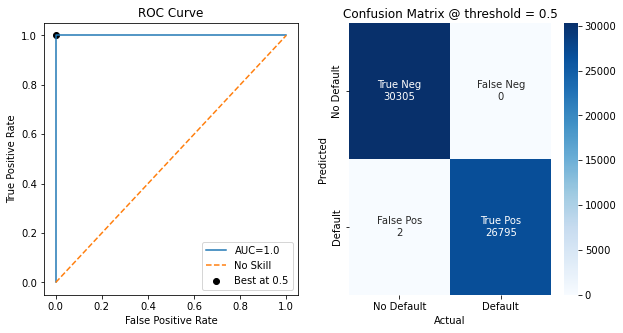

In [350]:
X,y = data.iloc[:,2:], data.iloc[:,0]
rf = RandomForestClassifier().fit(X,y)


model_result = print_confusion(model = rf, 
                              train_X = X, train_y = y, 
                              test_X = X, test_y = y, 
                              plots = True)

In [351]:
pd.Series(rf.feature_importances_, index = X.columns).sort_values(ascending= False)

PEG_1yrforward                            0.051052
PEG_trailing                              0.050564
bm                                        0.049322
req                                       0.048838
cshoq                                     0.048451
debt_assets                               0.048368
at_turn                                   0.047888
niq                                       0.046917
cogsq                                     0.046766
txtq                                      0.046426
pos_Announcements of Earnings             0.046058
ltq                                       0.045397
oiadpq                                    0.045103
revtq                                     0.045024
oibdpq                                    0.044789
atq                                       0.044768
lt_debt                                   0.042933
neg_Announcements of Earnings             0.034620
pos_Company Conference Presentations      0.024717
pos_Executive/Board Changes - O

In [322]:
# X = sm.add_constant(data.iloc[:,2:])
# y = data['dir']
# log_reg = sm.Logit(y,X).fit()
# log_reg.summary()

Optimization terminated successfully.
         Current function value: 0.687094
         Iterations 4


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                    dir   No. Observations:                57102
Model:                          Logit   Df Residuals:                    57069
Method:                           MLE   Df Model:                           32
Date:                Sat, 14 May 2022   Pseudo R-squ.:                0.006025
Time:                        21:19:34   Log-Likelihood:                -39234.
converged:                       True   LL-Null:                       -39472.
Covariance Type:            nonrobust   LLR p-value:                 1.878e-80
==========================================================================================================
                                             coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------
const                                     -0.0240      0.031     -0.775      0.438      -0.085       0.037
atq                                     3.765e-06   1.62e-06      2.331      0.020    5.99e-07    6.93e-06
cogsq                                   2.878e-05   1.32e-05      2.181      0.029    2.92e-06    5.46e-05
cshoq                                   5.926e-07   1.96e-05      0.030      0.976   -3.77e-05    3.89e-05
ltq                                    -3.824e-06    1.7e-06     -2.244      0.025   -7.16e-06   -4.84e-07
niq                                     8.905e-06    2.4e-05      0.371      0.711   -3.82e-05     5.6e-05
oiadpq                                     0.0002   5.49e-05      3.099      0.002    6.25e-05       0.000
oibdpq                                    -0.0001   5.03e-05     -2.938      0.003      -0.000   -4.92e-05
req                                    -2.368e-06   1.21e-06     -1.962      0.050   -4.73e-06   -2.92e-09
revtq                                  -1.862e-05   1.18e-05     -1.574      0.116   -4.18e-05    4.57e-06
txtq                                    1.451e-05   3.45e-05      0.420      0.674   -5.32e-05    8.22e-05
pos_Executive/Board Changes - Other       -0.8478      0.271     -3.124      0.002      -1.380      -0.316
pos_Announcements of Earnings              2.4500      0.253      9.669      0.000       1.953       2.947
pos_Dividend Affirmations                 -0.3403      0.228     -1.491      0.136      -0.788       0.107
pos_Dividend Increases                     0.8078      0.262      3.082      0.002       0.294       1.321
pos_Earnings Calls                         0.0365      0.292      0.125      0.900      -0.536       0.609
pos_Company Conference Presentations      -0.1822      0.194     -0.939      0.348      -0.563       0.198
pos_Earnings Release Date                 -0.1644      0.353     -0.465      0.642      -0.857       0.528
pos_Annual General Meeting                -0.4637      0.406     -1.142      0.253      -1.259       0.332
pos_Fixed Income Offerings                -0.1214      0.369     -0.329      0.742      -0.844       0.601
pos_Buyback Tranche Update                -1.3131      0.342     -3.839      0.000      -1.984      -0.643
neg_Executive/Board Changes - Other       -0.2246      0.831     -0.270      0.787      -1.853       1.404
neg_Announcements of Earnings             -5.0936      0.413    -12.328      0.000      -5.903      -4.284
neg_Corporate Guidance - New/Confirmed    -4.3505      0.673     -6.466      0.000      -5.669      -3.032
neg_Product-Related Announcements          2.3838      0.658      3.621      0.000       1.093       3.674
neg_Dividend Affirmations                 -2.4236      1.561     -1.553      0.120      -5.483       0.635
neg_Dividend Increases                     1.4035      2.945      0.477      0.634      -4.369       7.176
bm                             

In [323]:
# #keeping only the fields that were significant in multivariate regression
# sig = log_reg.tvalues[1:].reset_index()
# sig = sig[(sig[0]>=2) | (sig[0]<=-2)]
# keep= list(sig['index'].values)

In [324]:
# keep

['atq',
 'cogsq',
 'ltq',
 'oiadpq',
 'oibdpq',
 'pos_Executive/Board Changes - Other',
 'pos_Announcements of Earnings',
 'pos_Dividend Increases',
 'pos_Buyback Tranche Update',
 'neg_Announcements of Earnings',
 'neg_Corporate Guidance - New/Confirmed',
 'neg_Product-Related Announcements',
 'bm',
 'debt_assets']

In [377]:
#preparing clean final data
final = final[['cusip','dir','quarter']+keep].replace([np.inf, -np.inf], np.nan).dropna()
final.sort_values('quarter',inplace=True)
final['quarter'] = pd.to_datetime(final['quarter'].astype('str'))
# final.quarter = final.quarter.astype('category')
final.cusip = final.cusip.astype('category')
final.reset_index(drop=True,inplace=True)
final.head()

,cusip,dir,quarter,atq,cogsq,ltq,oiadpq,oibdpq,pos_Executive/Board Changes - Other,pos_Announcements of Earnings,pos_Dividend Increases,pos_Buyback Tranche Update,neg_Announcements of Earnings,neg_Corporate Guidance - New/Confirmed,neg_Product-Related Announcements,bm,debt_assets
0,00036110,1.0,2001-04-01,714.208,118.697,429.864,-0.171,5.513,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,1.107,0.547
1,83269630,0.0,2001-04-01,488.407,110.893,235.050,14.513,20.644,0.015714,0.043500,0.0,0.000000,0.000000,0.000000,0.0,0.410,0.410
2,83224810,0.0,2001-04-01,3850.442,1387.333,2510.406,122.156,156.134,0.120688,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.824,0.684
3,80706610,1.0,2001-04-01,1655.800,275.100,1121.600,112.200,120.700,0.000000,0.050948,0.0,0.071667,0.003619,0.000000,0.0,0.337,0.686
4,76316510,1.0,2001-04-01,316.160,85.689,203.995,5.069,6.498,0.000000,0.041213,0.0,0.052800,0.010705,0.010705,0.0,0.730,0.656


In [378]:
prices = pd.read_csv(PATH+'prices.csv')
# prices['date'] = pd.to_datetime(prices['date'])
prices['quarter'] = pd.to_datetime(prices.date).apply(lambda x: f'{x.year}Q{x.quarter}')
prices['quarter'] = pd.to_datetime(prices['quarter'].astype('str'))
prices['PRC'] = abs(prices['PRC'])
prices.drop('date', axis = 1, inplace= True)
prices.head()

,PERMNO,CUSIP,PRC,quarter
0,10001,36720410,8.12500,2000-01-01
1,10001,36720410,8.25000,2000-01-01
2,10001,36720410,8.00000,2000-01-01
3,10001,36720410,8.09375,2000-04-01
4,10001,36720410,7.90625,2000-04-01


In [379]:
ff = pd.read_csv(PATH+'ff_factors.csv')
ff['quarter'] = ff.Date.astype('str').apply(lambda x: f'{x[:4]}Q{(int(x[4:]) - 1)//3 + 1}')
ff.drop('Date', axis = 1, inplace= True)

ff['quarter'] = pd.to_datetime(ff['quarter'].astype('str'))
# ff.quarter = ff.quarter.astype('category')

ff.dropna()

,Mkt-RF,SMB,HML,RF,quarter
0,2.96,-2.38,-2.73,0.22,1926-07-01
1,2.64,-1.47,4.14,0.25,1926-07-01
2,0.36,-1.39,0.12,0.23,1926-07-01
3,-3.24,-0.13,0.65,0.32,1926-10-01
4,2.53,-0.16,-0.38,0.31,1926-10-01
...,...,...,...,...,...
1144,-1.55,-1.36,-0.42,0.00,2021-10-01
1145,3.10,-1.60,3.22,0.01,2021-10-01
1146,-6.25,-5.93,12.74,0.00,2022-01-01
1147,-2.29,2.18,3.09,0.00,2022-01-01


In [380]:
#creating datelist to loop over while creating portfolios
datelist = pd.date_range(pd.to_datetime('2002-12-31'), periods=73, freq='Q').tolist()

#store results for different kinds of cut-offs
results = pd.DataFrame(columns = ['50-50','60-40','70-30','80-20','90-10','95-05'])

# ROC_AUC Curve & Confusion matrix

In [381]:
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns

def print_confusion(model, train_X, train_y, test_X, test_y, plots = True):
    '''
    Prints the confusion matrix and accuracy score for the model
    Plots the confusion matrix if plots = True
    Plots the ROC curve
    '''
    y_pred_proba = model.predict_proba(test_X)[::,1] # Predict the probability of the positive class (default)

    #create ROC curve
    fpr, tpr, _ = metrics.roc_curve(test_y,  y_pred_proba) # Calculate the ROC curve
    auc = metrics.roc_auc_score(test_y, y_pred_proba) # Calculate the AUC score for the model
    
    # # Youden’s J statistic
    # metric = tpr - fpr
    # GMean Statistic
    metric = np.sqrt(tpr*(1-fpr)) # Calculate the GMean score for the model, This helps to determine the optimal threshold

    # Find index of largest value
    ix = np.argmax(metric) # Find the index of the largest value in the metric. This is the index of the optimal threshold (from the )
    
    threshold = round(_[ix],4) # Get the threshold value for the optimal threshold
    
    y_pred = np.where(y_pred_proba > threshold, 1, 0) # Predict the class for the test data
    test_acc = (test_y == y_pred).mean() # Calculate the accuracy score for the model
    
    if (test_y == model.predict(test_X)).mean() > test_acc: # Edge case handling
        threshold = 0.5

    train_acc = (train_y == np.where(model.predict_proba(train_X)[::,1] > threshold, 1, 0)).mean() # Calculate the training accuracy score for the model
    # print('\tTraining accuracy', round(train_acc,2))
    

    # print('\tValidation accuracy', round(test_acc,2))
    

    # print('\tValidation AUC-Score', round(auc,2))
    
    cf_matrix = metrics.confusion_matrix(test_y, y_pred) # Calculate the confusion matrix

    if plots: # Plot the confusion matrix and ROC curve
        fig, ax = plt.subplots(1,2, figsize=(10, 5))

        ax[0].plot(fpr,tpr,label="AUC="+str(round(auc,4)))
        ax[0].plot([0,1], [0,1], linestyle='--', label='No Skill')
        ax[0].scatter(fpr[ix], tpr[ix], marker='o', color='black', label= f'Best at {round(threshold, 4)}')
        ax[0].legend(loc=4)
        ax[0].set_ylabel('True Positive Rate')
        ax[0].set_xlabel('False Positive Rate')
        ax[0].set_title('ROC Curve')
        # plt.show()

        group_names = ['True Neg','False Neg','False Pos','True Pos']
        group_counts = ['{0:0.0f}'.format(value) for value in cf_matrix.flatten()]
        labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_names,group_counts)]
        # group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
        # labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
        labels = np.asarray(labels).reshape(2,2)
        
        ax[1] = sns.heatmap(cf_matrix, annot= labels, fmt= '', cmap='Blues')
        ax[1].set_xlabel('Actual')
        ax[1].set_ylabel('Predicted')
        ax[1].set_xticklabels(['No Default','Default'])
        ax[1].set_yticklabels(['No Default','Default'])
        ax[1].set_title(f'Confusion Matrix @ threshold = {round(threshold,2)}')
        plt.show()
        
    return {'train_acc': train_acc, 
            'test_acc': test_acc, 
            'threshold': threshold, 
            'auc': auc
        }


# Use it as: 
# 
# model_result = print_confusion(model = base_model, 
#                               train_X = X_train, train_y = y_train, 
#                               test_X = X_val, test_y = y_val, 
#                               plots = True)


# Long Short Portfolio

In [388]:
final

,cusip,dir,quarter,atq,cogsq,ltq,oiadpq,oibdpq,pos_Executive/Board Changes - Other,pos_Announcements of Earnings,pos_Dividend Increases,pos_Buyback Tranche Update,neg_Announcements of Earnings,neg_Corporate Guidance - New/Confirmed,neg_Product-Related Announcements,bm,debt_assets
0,00036110,1.0,2001-04-01,714.208,118.697,429.864,-0.171,5.513,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,1.107,0.547
1,83269630,0.0,2001-04-01,488.407,110.893,235.050,14.513,20.644,0.015714,0.043500,0.0,0.000000,0.000000,0.000000,0.000000,0.410,0.410
2,83224810,0.0,2001-04-01,3850.442,1387.333,2510.406,122.156,156.134,0.120688,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.824,0.684
3,80706610,1.0,2001-04-01,1655.800,275.100,1121.600,112.200,120.700,0.000000,0.050948,0.0,0.071667,0.003619,0.000000,0.000000,0.337,0.686
4,76316510,1.0,2001-04-01,316.160,85.689,203.995,5.069,6.498,0.000000,0.041213,0.0,0.052800,0.010705,0.010705,0.000000,0.730,0.656
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
156309,23251710,0.0,2020-07-01,82.526,11.577,18.987,2.134,2.729,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.015143,0.482,0.199
156310,35671D85,0.0,2020-07-01,41099.000,2410.000,23537.000,916.000,1361.000,0.000000,0.036020,0.0,0.052800,0.020500,0.020500,0.000000,1.320,0.572
156311,73927610,1.0,2020-07-01,876.068,54.698,96.271,14.741,21.819,0.000000,0.014636,0.0,0.000000,0.058364,0.058364,0.000000,0.284,0.108
156312,92346X20,1.0,2020-07-01,9.761,1.061,0.615,-0.983,-0.960,0.000000,0.019556,0.0,0.000000,0.052778,0.000000,0.000000,0.482,0.216


In [395]:
i = datelist[0]
i, i - datetime.timedelta(365)
final[(final['quarter'] <= i) & (final['quarter'] >= i - datetime.timedelta(365))]

,cusip,dir,quarter,atq,cogsq,ltq,oiadpq,oibdpq,pos_Executive/Board Changes - Other,pos_Announcements of Earnings,pos_Dividend Increases,pos_Buyback Tranche Update,neg_Announcements of Earnings,neg_Corporate Guidance - New/Confirmed,neg_Product-Related Announcements,bm,debt_assets
1454,59268810,0.0,2002-01-01,1203.647,143.627,796.424,30.782,36.749,0.000000,0.049571,0.000000,0.000000,0.040714,0.000000,0.000000,0.152,0.770
1455,76075910,0.0,2002-01-01,3872.000,342.000,2105.100,106.900,151.300,0.000000,0.033241,0.000000,0.052800,0.020931,0.000000,0.000000,0.705,0.537
1456,40377710,0.0,2002-01-01,219.947,69.953,70.204,9.761,16.255,0.000000,0.072162,0.000000,0.040429,0.042243,0.042243,0.000000,0.528,0.447
1457,43809210,0.0,2002-01-01,935.309,242.250,328.015,29.316,46.464,0.028289,0.058362,0.218333,0.040429,0.010085,0.010085,0.013977,0.478,0.429
1458,12189T10,0.0,2002-01-01,24897.000,1553.000,16958.000,380.000,610.000,0.000000,0.079529,0.000000,0.042667,0.000000,0.000000,0.041560,1.394,0.688
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7249,57053510,0.0,2002-10-01,7408.560,455.295,6249.449,51.233,53.862,0.000000,0.031529,0.177667,0.066000,0.000000,0.000000,0.000000,0.582,0.838
7250,48939920,0.0,2002-10-01,129.075,10.610,66.377,-2.852,-1.775,0.000000,0.110159,0.000000,0.000000,0.022741,0.000000,0.032817,1.201,0.549
7251,87165510,1.0,2002-10-01,223.605,52.145,86.570,4.806,7.825,0.000000,0.059167,0.000000,0.000000,0.000000,0.000000,0.000000,0.511,0.554
7252,36476010,0.0,2002-10-01,9902.004,2850.496,6243.792,425.297,597.476,0.000000,0.044727,0.000000,0.000000,0.070000,0.000000,0.000000,0.299,0.641


In [386]:
returns = pd.DataFrame()
def long_only(ub, lb):
    long = 1000000
    port_ret = []
    auc_list = []
    accuracy_list = []
    insample_accuracy_list = []
    
    for i in datelist:
        training = final[(final['quarter'] <= i) & (final['quarter'] >= i - datetime.timedelta(365))]
        predicting = final[(final['quarter'] <= i + datetime.timedelta(90)) & (final['quarter'] > i)]
        price = prices[(prices['quarter'] > i) & (prices['quarter'] <= i + datetime.timedelta(90))]

        X = training.iloc[:,3:]
        y = training['dir']
        clf = RandomForestClassifier().fit(X, y)

        model_result = print_confusion(model = clf, 
                              train_X = training.iloc[:,3:], train_y = training['dir'], 
                              test_X = predicting.iloc[:,3:], test_y = predicting['dir'], 
                              plots = False)
        auc_list.append(model_result['auc'])
        accuracy_list.append(model_result['test_acc'])
        insample_accuracy_list.append(model_result['train_acc'])

        temp = pd.DataFrame()
        temp['cusip'] = predicting['cusip']
        temp['Actual'] =  predicting['dir']
        temp[['Predicted_0','Predicted_1']] = clf.predict_proba(predicting.iloc[:,3:])
        temp = temp.merge(price, left_on =['cusip'],right_on= ['CUSIP'])

        initial = temp.groupby('cusip').first().reset_index()
        initial['inv'] = initial['Predicted_1'].apply(lambda x : True if x >= ub else np.nan)
        initial.dropna(inplace=True)
        if(len(initial[initial['inv'] == True])==0):
            port_ret.append(0)
            continue
        initial['shares'] = long/len(initial)
        initial['val'] = initial['PRC']*initial['shares']

        end = temp.groupby('cusip').last().reset_index()
        end = end.merge(initial, on='cusip')
        end['val_final'] = end['shares'] * end['PRC_x']
        end.dropna(subset=['val_final'],inplace=True)
        
        port_val_ini = sum(initial['val'])
        port_val_fin = sum(end['val_final'])
        
        ret = (port_val_fin - port_val_ini)/port_val_ini
        port_ret.append(round(ret,2))
    
    auc = np.round(np.mean(auc_list),4)
    print(f'Threshold: {ub}-{lb}')
    print('\tAverage AUC: ',auc)
    acc = np.round(np.mean(accuracy_list),4)
    print('\tAverage Validation Accuracy: ',acc)
    insample_acc = np.round(np.mean(insample_accuracy_list),4)
    print('\tAverage Train Accuracy: ',acc)
    return port_ret

In [387]:
returns_long = pd.DataFrame()
returns_long['Dates'] = datelist
returns_long['50'] = long_only(0.5,0.5)
returns_long['60'] = long_only(0.6,0.4)
returns_long['70'] = long_only(0.7,0.3)
returns_long['80'] = long_only(0.8,0.2)
returns_long['90'] = long_only(0.9,0.1)
returns_long['95'] = long_only(0.95,0.05)
returns_long

ValueError: Found array with 0 sample(s) (shape=(0, 14)) while a minimum of 1 is required.

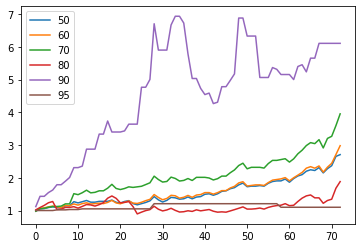

In [ ]:
cum_ret_long = returns_long.iloc[:,1:]+1
cum_ret_long = cum_ret_long.cumprod()
cum_ret_long.plot()

In [ ]:
returns_long['Dates'] = returns_long['Dates'].astype('str')
returns_long['Dates_M'] =returns_long['Dates'].apply(lambda x: x[0:4] + x[5:7])
returns_long['Dates_M'] = pd.to_numeric(returns_long['Dates_M'])
merged_long = returns_long.merge(ff, left_on=['Dates_M'],right_on=['Date'])
merged_long

In [55]:
X = sm.add_constant(merged_long.iloc[:,9:])
y = merged_long['60']
reg = sm.OLS(y,X, fit_intercept=True).fit()
reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     60   R-squared:                       0.074
Model:                            OLS   Adj. R-squared:                  0.019
Method:                 Least Squares   F-statistic:                     1.350
Date:                Mon, 02 May 2022   Prob (F-statistic):              0.261
Time:                        22:44:29   Log-Likelihood:                 133.27
No. Observations:                  73   AIC:                            -256.5
Df Residuals:                      68   BIC:                            -245.1
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0162      0.007      2.490      0.015       0.003       0.029
Mkt-RF        -0.0004      0.001     -0.273      0.786      -0.003       0.002
SMB            0.0034      0.002      1.409      0.163      -0.001       0.008
HML           -0.0030      0.002     -1.618      0.110      -0.007       0.001
RF            -0.0225      0.039     -0.570      0.570      -0.101       0.056
==============================================================================
Omnibus:                        2.092   Durbin-Watson:                   2.065
Prob(Omnibus):                  0.351   Jarque-Bera (JB):                2.043
Skew:                          -0.390   Prob(JB):                        0.360
Kurtosis:                       2.749   Cond. No.                         36.3
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [ ]:
X = sm.add_constant(merged_long.iloc[:,9:])
y = merged_long['60']
reg = sm.OLS(y,X, fit_intercept=True).fit()
reg.summary()

In [56]:
returns = pd.DataFrame()
def long_short(ub, lb):
    port_ret = []
    long = 1000000
    short = 1000000
    auc_list = []
    accuracy_list = []
    insample_accuracy_list = []
    for i in datelist:
        training = final[(final['quarter'] <= i) & (final['quarter'] >= i - datetime.timedelta(365))]
        predicting = final[(final['quarter'] <= i + datetime.timedelta(90)) & (final['quarter'] > i)]
        price = prices[(prices['date'] > i) & (prices['date'] <= i + datetime.timedelta(90))]

        X = training.iloc[:,3:]
        y = training['dir']
        clf = RandomForestClassifier().fit(X, y)

        model_result = print_confusion(model = clf, 
                              train_X = training.iloc[:,3:], train_y = training['dir'], 
                              test_X = predicting.iloc[:,3:], test_y = predicting['dir'], 
                              plots = False)
        auc_list.append(model_result['auc'])
        accuracy_list.append(model_result['test_acc'])
        insample_accuracy_list.append(model_result['train_acc'])

        temp = pd.DataFrame()
        temp['cusip'] = predicting['cusip']
        temp['Actual'] =  predicting['dir']
        temp[['Predicted_0','Predicted_1']] = clf.predict_proba(predicting.iloc[:,3:])
        temp = temp.merge(price, left_on =['cusip'],right_on= ['CUSIP'])

        initial = temp.groupby('cusip').first().reset_index()
        initial['inv'] = initial['Predicted_1'].apply(lambda x : True if x >= ub else (False if x <= lb else np.nan))
        initial.dropna(inplace=True)
        if(len(initial[initial['inv'] == True])==0 or len(initial[initial['inv'] == False])==0):
            port_ret.append(0)
            continue
        long_stocks = long/len(initial[initial['inv'] == True])
        short_stocks = short/len(initial[initial['inv'] == False])
        initial['val'] = initial['inv'].apply(lambda x: long_stocks if x else short_stocks)
        initial['shares'] = initial['val']/initial['PRC']

        end = temp.groupby('cusip').last().reset_index()
        end = end.merge(initial, on='cusip')
        end['val_final'] = end['shares'] * end['PRC_x']
        end.dropna(subset=['val_final'],inplace=True)
        port_val = abs(sum(end['val_final']))
        port_val_initial = abs(sum(initial['val']))
        ret = (port_val - port_val_initial)/port_val_initial
        port_ret.append(round(ret,2))
    
    auc = np.round(np.mean(auc_list),4)
    print(f'Threshold: {ub}-{lb}')
    print('\tAverage AUC: ',auc)
    acc = np.round(np.mean(accuracy_list),4)
    print('\tAverage Validation Accuracy: ',acc)
    insample_acc = np.round(np.mean(insample_accuracy_list),4)
    print('\tAverage Train Accuracy: ',insample_acc)
    return port_ret

In [57]:
returns = pd.DataFrame()
returns['Dates'] = datelist
returns['50'] = long_short(0.5,0.5)
returns['60'] = long_short(0.6,0.4)
returns['70'] = long_short(0.7,0.3)
returns['80'] = long_short(0.8,0.2)
returns['90'] = long_short(0.9,0.5)
returns['95'] = long_short(0.95,0.05)

Threshold: 0.5-0.5
	Average AUC:  0.5889
	Average Validation Accuracy:  0.5684
Threshold: 0.6-0.4
	Average AUC:  0.5895
	Average Validation Accuracy:  0.5677
Threshold: 0.7-0.3
	Average AUC:  0.59
	Average Validation Accuracy:  0.5666
Threshold: 0.8-0.2
	Average AUC:  0.5893
	Average Validation Accuracy:  0.5649
Threshold: 0.9-0.5
	Average AUC:  0.5896
	Average Validation Accuracy:  0.5682
Threshold: 0.95-0.05
	Average AUC:  0.5901
	Average Validation Accuracy:  0.5683


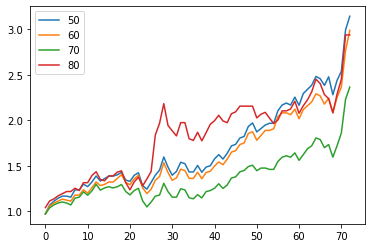

In [58]:
cum_ret = (returns.iloc[:,1:5]) + 1
cum_ret = cum_ret.cumprod()
cum_ret.plot()

In [59]:
returns['Dates'] = returns['Dates'].astype('str')
returns['Dates_M'] = returns['Dates'].apply(lambda x: x[0:4] + x[5:7])
returns['Dates_M'] = pd.to_numeric(returns['Dates_M'])

In [60]:
merged = returns.merge(ff, left_on=['Dates_M'],right_on=['Date'])
X = sm.add_constant(merged.iloc[:,9:])
y = merged['60']
reg = sm.OLS(y,X, fit_intercept=True).fit()
reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     60   R-squared:                       0.080
Model:                            OLS   Adj. R-squared:                  0.026
Method:                 Least Squares   F-statistic:                     1.476
Date:                Mon, 02 May 2022   Prob (F-statistic):              0.219
Time:                        22:51:20   Log-Likelihood:                 124.03
No. Observations:                  73   AIC:                            -238.1
Df Residuals:                      68   BIC:                            -226.6
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0165      0.007      2.230      0.029       0.002       0.031
Mkt-RF         0.0002      0.002      0.116      0.908      -0.003       0.003
SMB            0.0035      0.003      1.286      0.203      -0.002       0.009
HML           -0.0039      0.002     -1.868      0.066      -0.008       0.000
RF            -0.0261      0.045     -0.583      0.562      -0.115       0.063
==============================================================================
Omnibus:                        0.850   Durbin-Watson:                   2.044
Prob(Omnibus):                  0.654   Jarque-Bera (JB):                0.324
Skew:                          -0.024   Prob(JB):                        0.850
Kurtosis:                       3.323   Cond. No.                         36.3
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""